In [185]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [62]:
sns.set_palette("pastel")

## Descriptive Statistics

In [6]:
# Set the new working directory
new_path = 'C:/Users/1412r/Buynomics'
os.chdir(new_path)

Current directory is now: C:\Users\1412r\Buynomics


In [46]:
# Read product data
file_path = 'question-custom-takehome-project-m8li6z2dnc-data/data/product.csv'
product = pd.read_csv(file_path)

# Read sales data
file_path = 'question-custom-takehome-project-m8li6z2dnc-data/data/sales.csv'
sales = pd.read_csv(file_path)

# Drop index column
product = product.drop(['Unnamed: 0'], axis=1)
sales = sales.drop(['Unnamed: 0'], axis=1)

In [42]:
# Look at the sales data
sales.head()

,date,product_id,price,units
0,2020-01-01,0,4.65,1126.0
1,2020-01-02,0,4.76,1205.0
2,2020-01-03,0,5.22,1007.0
3,2020-01-04,0,5.45,1282.0
4,2020-01-05,0,3.33,1037.0


In [48]:
# Look at the product data
product.head()

,brand,flavour,volume_per_joghurt_g,packsize,product_id
0,Mueller,blueberry,150,6,0
1,Oikos,chocolate,1000,1,1
2,Alnatura,strawberry,1000,1,2
3,Mueller,straciatella,500,6,3
4,Danone,straciatella,150,6,4


In [70]:
df = pd.merge(sales, product, on='product_id', how='left')

In [82]:
# Numeric summaries for sales data
print(sales[['price', 'units']].describe())

            price        units
count  260.000000   260.000000
mean     5.288538  1177.496154
std      1.881547   401.771103
min      1.460000    16.000000
25%      3.965000   944.000000
50%      5.140000  1275.500000
75%      6.785000  1453.250000
max      9.420000  2170.000000


In [86]:
# Summary for product categorical and numeric features
print(product.describe(include='all'))

         brand    flavour  volume_per_joghurt_g   packsize  product_id
count       27         27             27.000000  27.000000   27.000000
unique       9          5                   NaN        NaN         NaN
top     Danone  blueberry                   NaN        NaN         NaN
freq         5          7                   NaN        NaN         NaN
mean       NaN        NaN            625.925926   4.703704   13.000000
std        NaN        NaN            342.886607   2.232880    7.937254
min        NaN        NaN            150.000000   1.000000    0.000000
25%        NaN        NaN            500.000000   3.500000    6.500000
50%        NaN        NaN            500.000000   6.000000   13.000000
75%        NaN        NaN           1000.000000   6.000000   19.500000
max        NaN        NaN           1000.000000   6.000000   26.000000


In [90]:
# Look at correlations in sales_df
print(sales[['price', 'units']].corr())

          price     units
price  1.000000 -0.704612
units -0.704612  1.000000


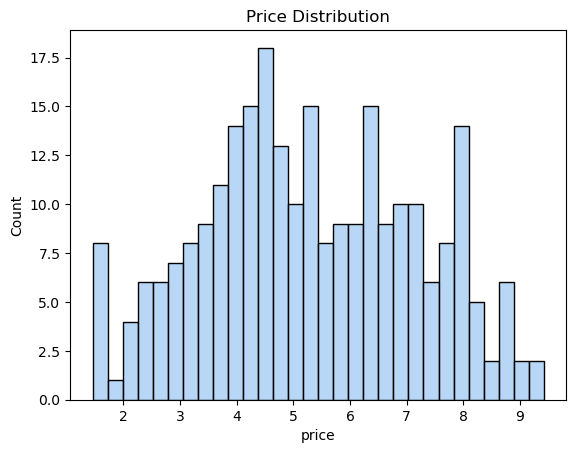

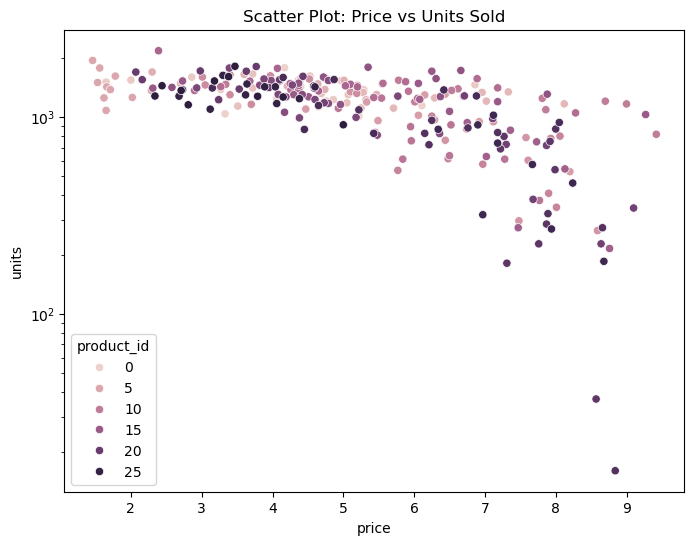

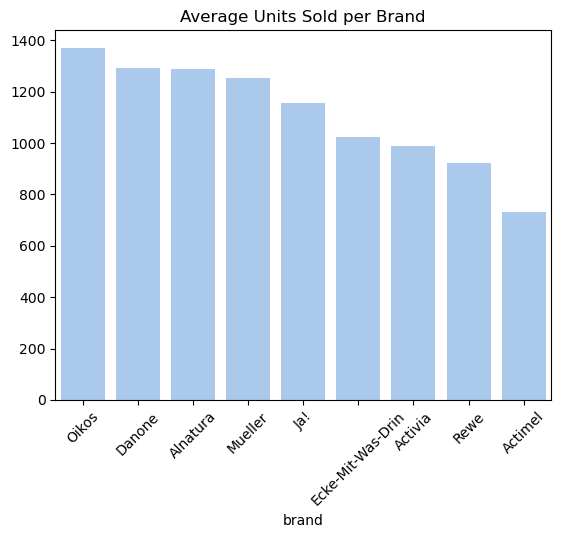

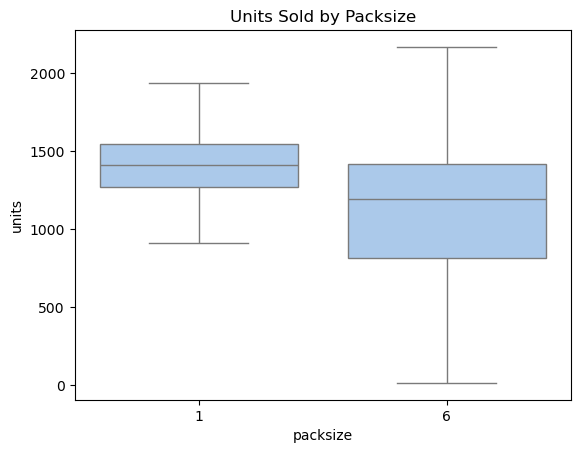

In [96]:
# Distribution of price
sns.histplot(df['price'], bins=30)
plt.title('Price Distribution')
plt.show()

# Scatter plot price vs units (log scale to handle range)
plt.figure(figsize=(8,6))
sns.scatterplot(x='price', y='units', data=df, hue='product_id')
plt.yscale('log')
plt.title('Scatter Plot: Price vs Units Sold')
plt.show()

# Average units sold per brand
brand_sales = df.groupby('brand')['units'].mean().sort_values(ascending=False)
sns.barplot(x=brand_sales.index, y=brand_sales.values)
plt.xticks(rotation=45)
plt.title('Average Units Sold per Brand')
plt.show()

# Boxplot of units sold per packsize (categorical)
sns.boxplot(x='packsize', y='units', data=df)
plt.title('Units Sold by Packsize')
plt.show()

### Executive Summary
1. The price sensitivity observed suggests that adjusting prices will significantly affect sales volumes.

2. Product characteristics such as brand, flavour, packsize, and volume vary enough to justify including them in a sales prediction model.

3. Danone and blueberry flavour appear as dominant categories which might be key drivers in the product mix.

4. The large variation in packsize and volume suggests customers buy different package formats, which could affect demand differently.

## Simple Model Predicting Units from Price & Product Attributes
Approach: Log-Linear Regression to capture elasticities
Elasticity means % change in units sold for a % change in price, so modeling log(units) ~ log(price) + product features is common.

### Using OLS

In [174]:
# Add log transforms (add a small number to avoid log(0))
df['log_units'] = np.log(df['units'] + 1)
df['log_price'] = np.log(df['price'] + 1e-6)

# Convert categorical variables to dummies (brand, flavour)
df_model = pd.get_dummies(df[['brand', 'flavour']], drop_first=True)
df_model['log_units'] = df['log_units']
df_model['log_price'] = df['log_price']
df_model['packsize'] = df['packsize']
df_model['product_id'] = df['product_id']

# Define X and y
X = df_model.drop('log_units', axis=1)
y = df_model['log_units']

# Add constant for intercept
X = sm.add_constant(X)
X = X.astype(float)

# Fit linear regression model
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     15.86
Date:                Tue, 22 Jul 2025   Prob (F-statistic):           2.21e-28
Time:                        01:31:32   Log-Likelihood:                -134.18
No. Observations:                 260   AIC:                             300.4
Df Residuals:                     244   BIC:                             357.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

#### Evaluate model vs baseline
Baseline: predict average log_units (mean of y)

Compute RMSE or MAE for both model and baseline

In [151]:
# Predictions
y_pred = model.predict(X)

# Baseline prediction (mean of y)
y_baseline = np.full_like(y, y.mean())

# RMSE
rmse_model = np.sqrt(mean_squared_error(y, y_pred))
rmse_baseline = np.sqrt(mean_squared_error(y, y_baseline))

print(f'Model RMSE: {rmse_model:.3f}')
print(f'Baseline RMSE: {rmse_baseline:.3f}')

Model RMSE: 0.405
Baseline RMSE: 0.570


### Using ML (Random Forest)

In [189]:
# Features and target
features = ['price', 'brand', 'flavour', 'packsize']  # add relevant features

# One-hot encode categorical features
df_ml = pd.get_dummies(df[features], drop_first=True)

# Target: units sold (or log_units if you want)
y = np.log(df['units'] + 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df_ml, y, test_size=0.2, random_state=42)

# Initialize and train model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Random Forest RMSE: {rmse:.2f}')

Random Forest RMSE: 0.55


#### Evaluate model vs baseline
OLS RMSE was 0.405 (better on log scale).
Random Forest RMSE is 0.55 (slightly worse in this case).

Possible reasons:

1. Small dataset (~260 observations) may limit the benefit of complex models.
2. Features or preprocessing might not be optimal for RF.
3. RF can struggle on very skewed data or small samples without tuning.

### Key Findings from Coefficients
Intercept (const): 7.838, baseline expected log units when all other variables are at their reference/baseline.

Price elasticity (log_price):
Coefficient = -0.6143, significant at p < 0.001
Interpretation: A 1% increase in price is associated with approximately a 0.61% decrease in units sold, holding other factors constant.
This aligns well with the earlier strong negative correlation (-0.70) between price and units.

Brand effects:
Some brands show positive significant effects compared to the reference brand (not shown here but omitted in dummies), e.g.:

Alnatura (coef 0.44, p=0.031)

Mueller (coef 0.41, p=0.02)
These brands tend to have higher sales volume controlling for price and other factors.

Flavour effects:

Chocolate (coef 0.27, p=0.003) and Straciatella (coef 0.32, p<0.001) flavours are associated with higher units sold.

Strawberry and Raspberry flavours show negative or borderline effects.

Packsize:
Negative coefficient (-0.035, p=0.063) suggests a trend where larger packs might sell slightly fewer units per transaction, but this effect is only marginally significant.

Product_id:
No significant effect, likely because other variables explain the variation well.

Model Fit & Evaluation
RMSE (Root Mean Squared Error) of model: 0.405

Baseline RMSE (predicting mean only): 0.570

The model improves prediction error over baseline by a noticeable margin, showing reasonable predictive power.



### Executive Summary
1. Price has a meaningful negative impact on sales, consistent with expected price elasticity in consumer goods.

2. Certain brands and flavours drive higher sales volume even after controlling for price, which can guide marketing or product positioning.

3. Packsize might slightly affect sales volume, possibly reflecting consumer preferences for pack formats.

4. The model can be used to predict how changing price or product attributes could affect sales volumes (log scale), enabling price optimization and strategic decisions.

## Revenue Optimization Simulation
Revenue = price * units_sold
Simulate how changing prices affects predicted units and revenue:

In [178]:
# Create a function to predict units for new prices

def predict_units(new_prices, X_template):
    # new_prices: pandas Series indexed by same order as X_template rows
    X_new = X_template.copy()
    X_new['log_price'] = np.log(new_prices + 1e-6)
    # Predict log_units
    log_units_pred = model.predict(X_new)
    # Convert back to units
    units_pred = np.exp(log_units_pred) - 1
    return units_pred.clip(lower=0)  # no negative units

# Simulate a 10% price increase for all products

original_prices = df['price']
price_increase = original_prices * 1.10

units_predicted = predict_units(price_increase, X)

# Calculate revenue before and after price change
revenue_original = original_prices * df['units']
revenue_new = price_increase * units_predicted

print(f"Total revenue original: {revenue_original.sum():.2f}")
print(f"Total revenue with 10% price increase: {revenue_new.sum():.2f}")

Total revenue original: 1481123.77
Total revenue with 10% price increase: 1458292.33


### Executive Summary
The simulation shows that a uniform price increase reduces total revenue slightly (~€23k less), despite the higher prices, because the predicted drop in units sold outweighs the price gain.

This demonstrates the price sensitivity (elasticity) captured by your model and highlights the importance of balancing price and volume to optimize revenue.



## Conclusion
1. Data Exploration:
    1. Sales and product data reveal a strong negative correlation (-0.70) between price and units sold, consistent with standard demand theory.
    2. Product characteristics (brand, flavour, pack size) vary meaningfully and influence sales.

2. Modelling:
    1. A log-linear regression predicting log(units) from log(price) and product attributes explains about 49% of sales variance.
    2. The price elasticity estimate of about -0.61 means a 1% price increase leads to roughly a 0.61% decrease in units sold.
    3. Significant brand and flavour effects suggest product mix matters for sales volumes.

3. Revenue Simulation:
    1. Using the model to simulate a uniform 10% price increase predicts a slight decrease in total revenue, illustrating how price increases may backfire without considering demand sensitivity.
    2. This simulation approach provides actionable insights for pricing strategy by balancing price and sales volume.